In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import shutil
import random
from PIL import Image
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
import warnings
import tensorflow as tf
from pathlib import Path

tf.random.set_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')


**Uploading the Kaggle API JSON file**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedhambuta","key":"740b6a3b29045b6769982962d8c436f5"}'}

In [ ]:
# Create .kaggle directory and move the token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify it's set up
!kaggle --version

Kaggle API 1.7.4.5


**Downloading the dataset**

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

!unzip -q animals10.zip -d /content/animals10
print("✓ Dataset downloaded and extracted!")

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 98% 575M/586M [00:03<00:00, 112MB/s] 
100% 586M/586M [00:03<00:00, 157MB/s]
✓ Dataset downloaded and extracted!


In [ ]:
from collections import Counter

data_path = "/content/animals10/raw-img"
classes = os.listdir(data_path)

label_map = {
    "gatto": "cat",
    "cavallo": "horse",
    "scoiattolo": "squirrel",
    "gallina": "chicken",
    "farfalla": "butterfly",
    "ragno": "spider",
    "cane": "dog",
    "pecora": "sheep",
    "elefante": "elephant",
    "mucca": "cow"
}

counts = {}
for cls in classes:
    english_cls_name = label_map.get(cls, cls)

    num_images = len(os.listdir(os.path.join(data_path, cls)))

    counts[english_cls_name] = num_images

counts.keys()

dict_keys(['spider', 'squirrel', 'cat', 'horse', 'dog', 'chicken', 'sheep', 'cow', 'butterfly', 'elephant'])

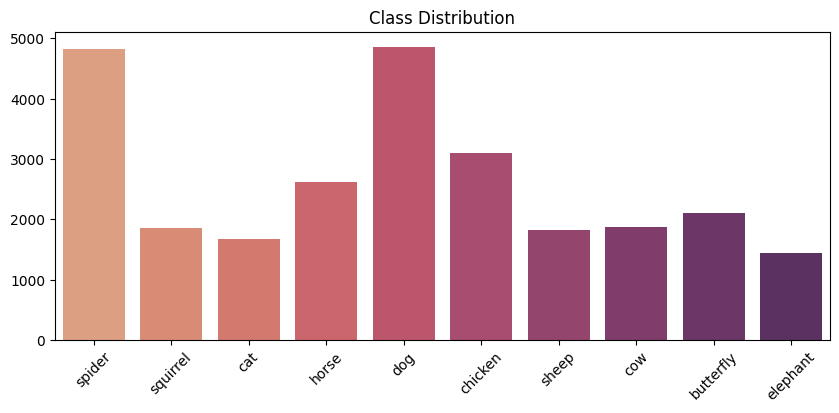

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(x = counts.keys(), y = counts.values(), palette= 'flare')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

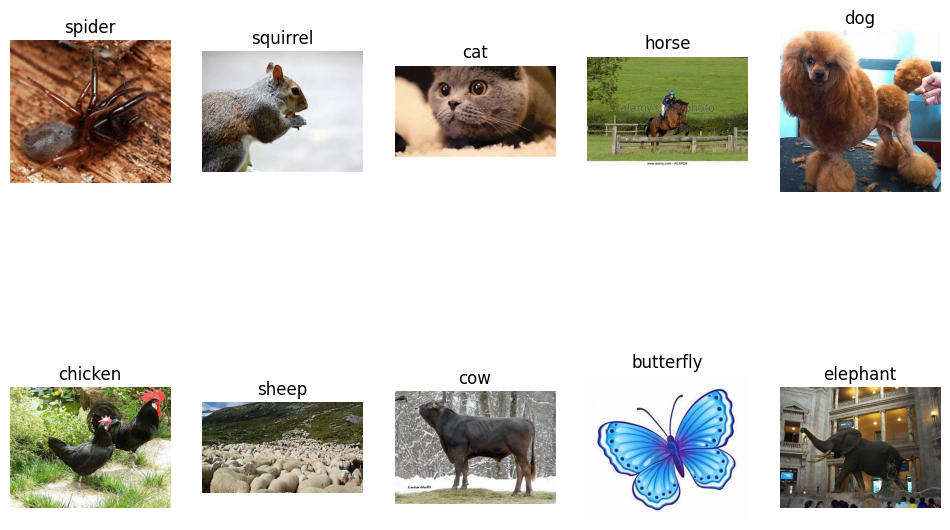

In [ ]:
plt.figure(figsize=(12, 8))

for i, cls in enumerate(classes[:10]):
    english_cls_name = label_map.get(cls, cls)
    img_name = random.choice(os.listdir(os.path.join(data_path, cls)))
    img_path = os.path.join(data_path, cls, img_name)

    img = mpimg.imread(img_path)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(english_cls_name)
    plt.axis('off')

plt.show()

In [ ]:
sizes = []

for cls in classes:
    for img in os.listdir(os.path.join(data_path, cls))[:100]:
        path = os.path.join(data_path, cls, img)
        try:
            with Image.open(path) as im:
                sizes.append(im.size)
        except:
            pass

sizes[:10]

[(300, 225),
 (300, 149),
 (300, 285),
 (300, 246),
 (640, 426),
 (300, 225),
 (300, 169),
 (300, 199),
 (300, 197),
 (235, 198)]

**Data Have Varoius Image Sizes**

**Splitting the data to Training , validation And Testing Folders**

In [ ]:
import os
import shutil
import random
from pathlib import Path

DATA_DIR = Path("/content/animals10")   # Data Directory
TRAIN_DIR = Path("/content/Training")   # Training Directory
VAL_DIR = Path("/content/Validation")   # Validation Directory
TEST_DIR = Path("/content/Testing")     # Testing Directory

# Remove old folders if they exist
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if d.exists():
        shutil.rmtree(d)

# Re-create new clean folders
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VAL_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
TRAIN_SPLIT = 0.8   # 80% train+val
VAL_SPLIT = 0.1     # 10% of the training split  (0.1 * 0.8 = 0.08)
TEST_SPLIT = 0.2    # 20% test

SOURCE_DATA_PATH = DATA_DIR / "raw-img"
class_names = sorted([d.name for d in SOURCE_DATA_PATH.iterdir() if d.is_dir()])

# Create class folders for train, val, test
for cname in class_names:
    (TRAIN_DIR / cname).mkdir(parents=True, exist_ok=True)
    (VAL_DIR / cname).mkdir(parents=True, exist_ok=True)
    (TEST_DIR / cname).mkdir(parents=True, exist_ok=True)

for cname in class_names:
    imgs = list((SOURCE_DATA_PATH / cname).glob("*"))
    random.Random(SEED).shuffle(imgs)

    total = len(imgs)
    train_val_end = int(total * TRAIN_SPLIT)   # 80%
    train_end = int(train_val_end * (1 - VAL_SPLIT))  # 90% of 80% = 72%

    # Splits
    train_imgs = imgs[:train_end]                 # 72%
    val_imgs = imgs[train_end:train_val_end]      # 8%
    test_imgs = imgs[train_val_end:]              # 20%

    # Copy training images
    for img_path in train_imgs:
        shutil.copy(img_path, TRAIN_DIR / cname / img_path.name)

    # Copy validation images
    for img_path in val_imgs:
        shutil.copy(img_path, VAL_DIR / cname / img_path.name)

    # Copy testing images
    for img_path in test_imgs:
        shutil.copy(img_path, TEST_DIR / cname / img_path.name)

print("✓ Train, Validation, and Test folders created successfully!")

✓ Train, Validation, and Test folders created successfully!


**Directories**

In [ ]:
train_dir = '/content/Training'
test_dir = '/content/Testing'
val_dir = '/content/Validation'

**Preparing the dataset**

In [ ]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=8, # to reduce the ram utilization
    label_mode='categorical', # More than one 2 targets
    shuffle=True,
    seed=100
)

Found 18841 files belonging to 10 classes.


**Preparing the testing set**

In [ ]:
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=8, # to reduce the ram utilization
    label_mode='categorical', # More than one 2 targets
    shuffle=False
)

Found 5241 files belonging to 10 classes.


**preparing validation set**

In [ ]:
val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(128, 128),
    batch_size=8, # to reduce the ram utilization
    label_mode='categorical', # More than one 2 targets
    shuffle=False
)

Found 2097 files belonging to 10 classes.


**Use the model preprocessing method for data**

In [ ]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# Optimize input pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

**Data Augmentation to reduce Overfitting**

In [ ]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape= (128, 128, 3)),
    tf.keras.layers.RandomRotation(0.05),
])

**Images Before And after Augmetation and Reshaping**

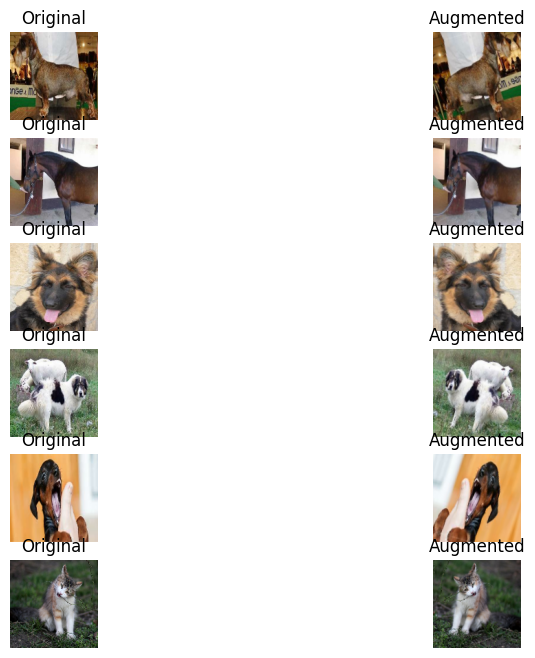

In [ ]:
for images, labels in train_ds.take(1):
    augmented = data_augmentation(images)

    plt.figure(figsize=(10, 8))

    for i in range(6):
        plt.subplot(6, 2, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(6, 2, 2*i + 2)
        plt.imshow(augmented[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

    plt.show()

**Model CallBacks**

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True,),
    ReduceLROnPlateau(monitor= 'val_loss', patience= 3, verbose= 1, min_lr=1e-7,),
]

**Using Pretrained Model (EfficientNetB0)**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Input layer
inputs = Input(shape=(128, 128, 3))

x = data_augmentation(inputs)

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False

x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[1][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
history = model.fit(
    train_ds,
    callbacks= callbacks,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.8245 - loss: 0.6768 - val_accuracy: 0.9418 - val_loss: 0.1941 - learning_rate: 1.0000e-04
Epoch 2/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.9373 - loss: 0.2055 - val_accuracy: 0.9509 - val_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 3/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9455 - loss: 0.1686 - val_accuracy: 0.9499 - val_loss: 0.1674 - learning_rate: 1.0000e-04
Epoch 4/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.9528 - loss: 0.1495 - val_accuracy: 0.9518 - val_loss: 0.1621 - learning_rate: 1.0000e-04
Epoch 5/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.9616 - loss: 0.1288 - val_accuracy: 0.9561 - val_loss: 0.1559 - learning_rate: 1.0000e-04
Epoch 6/10
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.9651 - loss: 0.1076 - val_accuracy: 0.9566 - val_loss: 0.1526 - learning_rate: 1.0000e-04
Epoch 7/10
2356/2356 ━━━━━━━━━━━━━━━━━━━

**Fine Tuning**

In [ ]:
for layer in base_model.layers[-30:]: #un freeze the last 30 layers
    layer.trainable = True


model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB0 95% Accuracy

In [ ]:
history = model.fit(
    train_ds,
    callbacks= callbacks,
    validation_data=val_ds,
    epochs=15,
    verbose=1
)

Epoch 1/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.8496 - loss: 0.4609 - val_accuracy: 0.9466 - val_loss: 0.2019 - learning_rate: 1.0000e-05
Epoch 2/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.8951 - loss: 0.3258 - val_accuracy: 0.9504 - val_loss: 0.1843 - learning_rate: 1.0000e-05
Epoch 3/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.9023 - loss: 0.2876 - val_accuracy: 0.9552 - val_loss: 0.1768 - learning_rate: 1.0000e-05
Epoch 4/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.9196 - loss: 0.2475 - val_accuracy: 0.9552 - val_loss: 0.1713 - learning_rate: 1.0000e-05
Epoch 5/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.9299 - loss: 0.2163 - val_accuracy: 0.9566 - val_loss: 0.1699 - learning_rate: 1.0000e-05
Epoch 6/15
2356/2356 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - accuracy: 0.9339 - loss: 0.1974 - val_accuracy: 0.9547 - val_loss: 0.1712 - learning_rate: 1.0000e-05
Epoch 7/15
2356/2356 ━━━━━━━━━━━━━━━━━━━

**Plotting the Validation Accuracy vs the Training Accuracy**

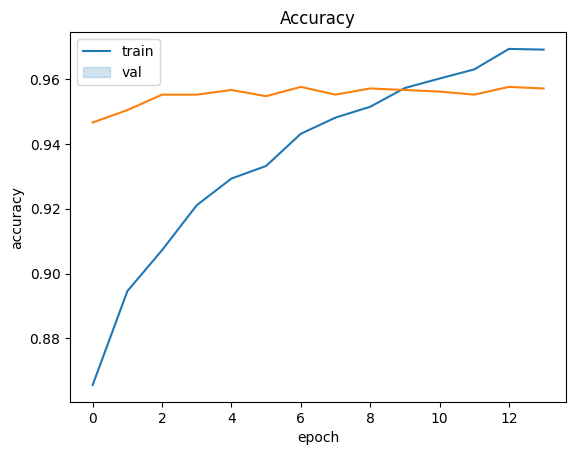

In [ ]:
history_df= pd.DataFrame(history.history)
sns.lineplot(history_df['accuracy'])
sns.lineplot(history_df['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, ..., 9, 9, 9])

In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred = y_pred_probs.argmax(axis=1)
y_pred

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

evalution_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Score": [accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='macro'), recall_score(y_true, y_pred, average='macro'), f1_score(y_true, y_pred, average='macro')],
})
sns.barplot(data= evalution_df, x= 'Metric', y= 'Score', palette='flare')
plt.title("Evaluation Metrics")
sns.set_style('darkgrid')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
label_map

**Saveing the Model**

In [ ]:
tf.keras.models.save_model(model, 'image_classification_model.keras')

# 🐾 Animal Image Classification: Final Report

## **Dataset Overview**
- **Number of classes:** 10 animals (in Italian language)  
- **Image characteristics:** Various sizes across the dataset  
- **Data distribution:** Slightly imbalanced  

---

## **Steps Taken**

### **1️⃣ Data Preparation**
- Split the dataset into **Training, Testing, and Validation** sets  
- Ensured **no overlapping images** between splits  
- Partitioned data as follows:  
  - **Training:** 80%  
  - **Testing:** 20%  
  - **Validation:** 10% of the training set  

### **2️⃣ Preprocessing**
- Resized all images to **128×128 pixels**  
- Applied **EfficientNetB0 preprocessing**  
- Used **data augmentation** to reduce overfitting  
- Added **callbacks**:  
  - **Early Stopping**  
  - **Reduce Learning Rate**  

### **3️⃣ Modeling**
- **Feature Extraction:**  
  - Frozen pretrained layers  
  - Trained new layers on the dataset  
- **Fine-tuning:**  
  - Unfroze all layers  
  - Trained the entire model for improved performance  
- **Result:** Achieved **95% training accuracy**  

### **4️⃣ Testing & Evaluation**
- Tested the model on the **testing dataset**  
- Metrics used:  
  - **Accuracy** ✅  
  - **Precision** ✅  
  - **Recall** ✅  
  - **F1-Score** ✅  
- **Result:** Average **95% accuracy** across metrics  
- **Model saved** as a **.keras file** for future use  

---

## **Summary**
The EfficientNetB0-based model successfully classified 10 animal classes with **high accuracy and reliable metrics**, demonstrating strong generalization on unseen data.
